# 0. Import packages

In [25]:
import torch
from torch import nn
import transformers
from transformers import AutoConfig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1. Summary
- **attention** is all u need
    - encoder: sequence of tokens -> sequence of embedding vectors(hidden state/context)
    - decoder: encoder's hidden state -> sequence of tokens
        - iteratively generate, until EOS or reach max length limit
        - one token at one time

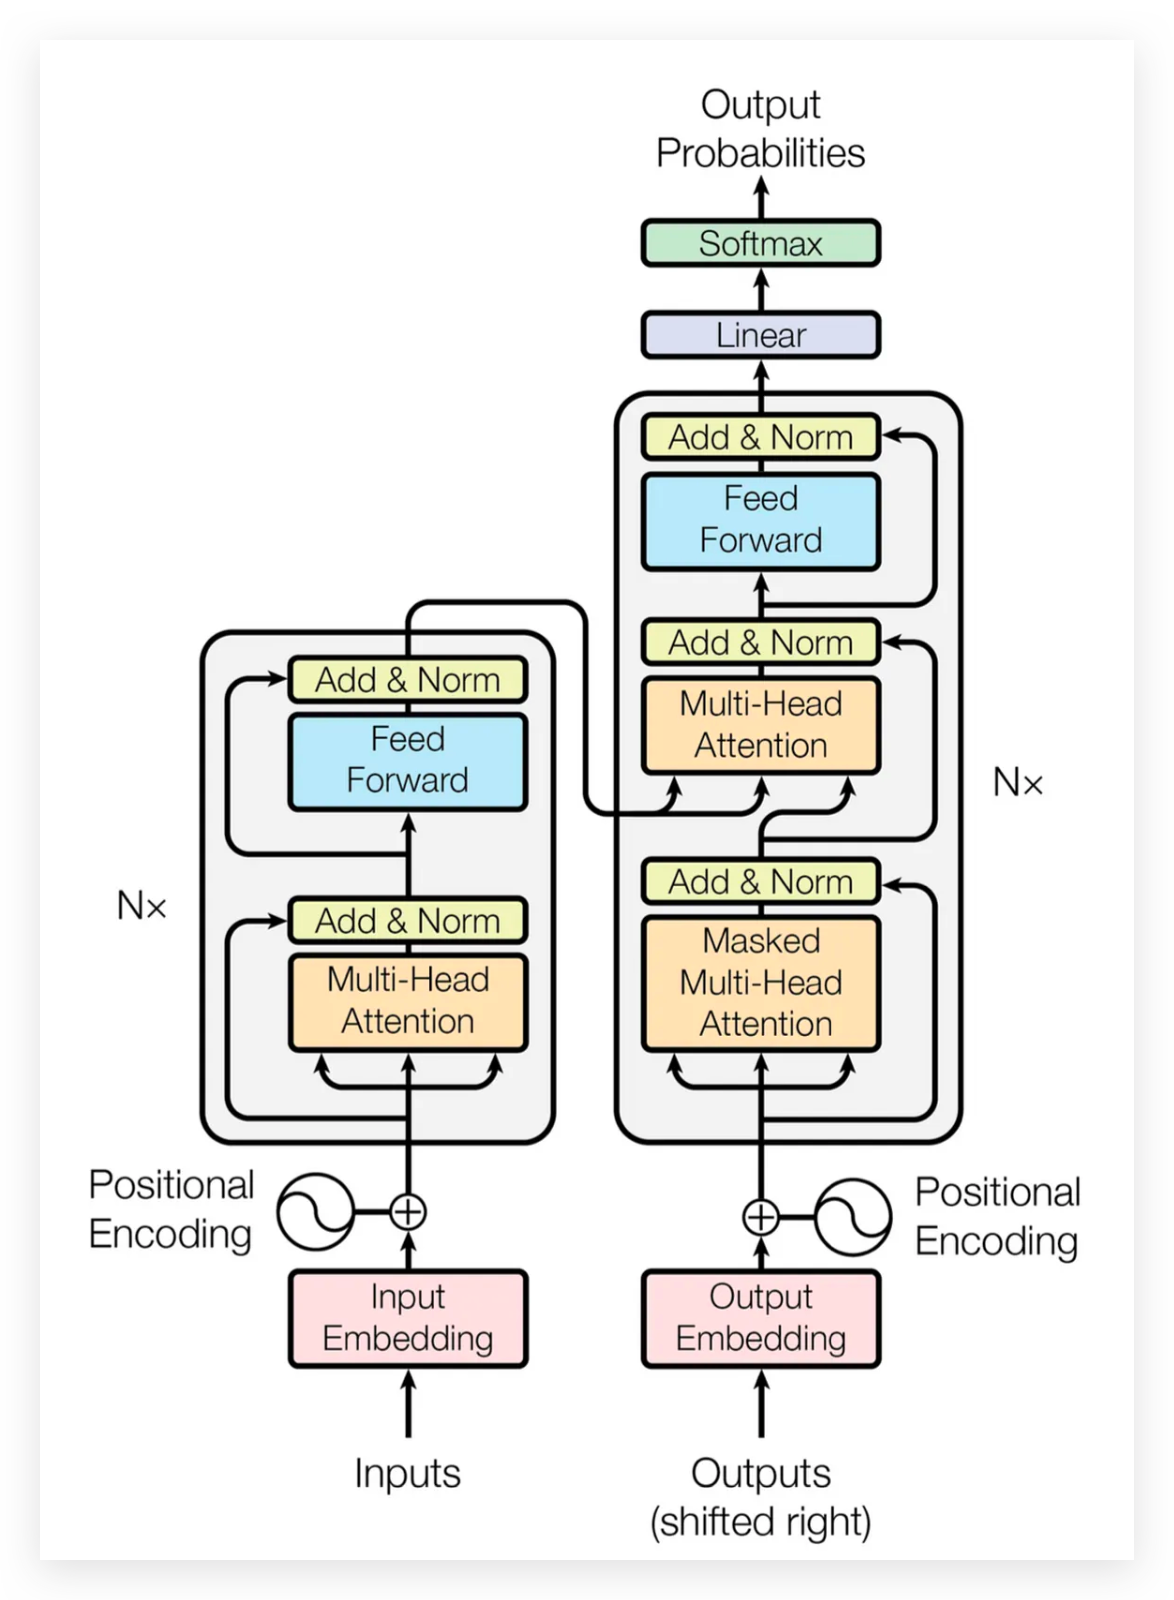

In [8]:
from IPython.display import Image
Image(filename="Images/transformer.png", width=400)

### Different use of **encoder** and **decoder**:
- encoder only -> rich representation
- decoder only -> rich representation of left elements
- encoder-decoder both

# 2. encoder
- encoder layer stack (N)
    - input: sequence of embeddings
    - output: same shape sequence with rich representation

## 2.1 multi-head self-attention layer

### 2.1.1 self attention

Self-attention is the core mechanism of Transformers. 
- It allows each token in a sequence to look at all other tokens and decide which ones are most relevant for its representation.
- The model projects the input into **queries (Q)**, **keys (K)**, and **values (V)**.
- The **attention scores** are computed by taking the dot product of **Q** and **K**, normalized with softmax, and then used **attention weights** to weight the **V**.

This way, each token’s final representation is a context-aware mixture of all tokens, enabling the model to capture long-range dependencies efficiently and in parallel.

### 2.1.2 scaled dot-product attention

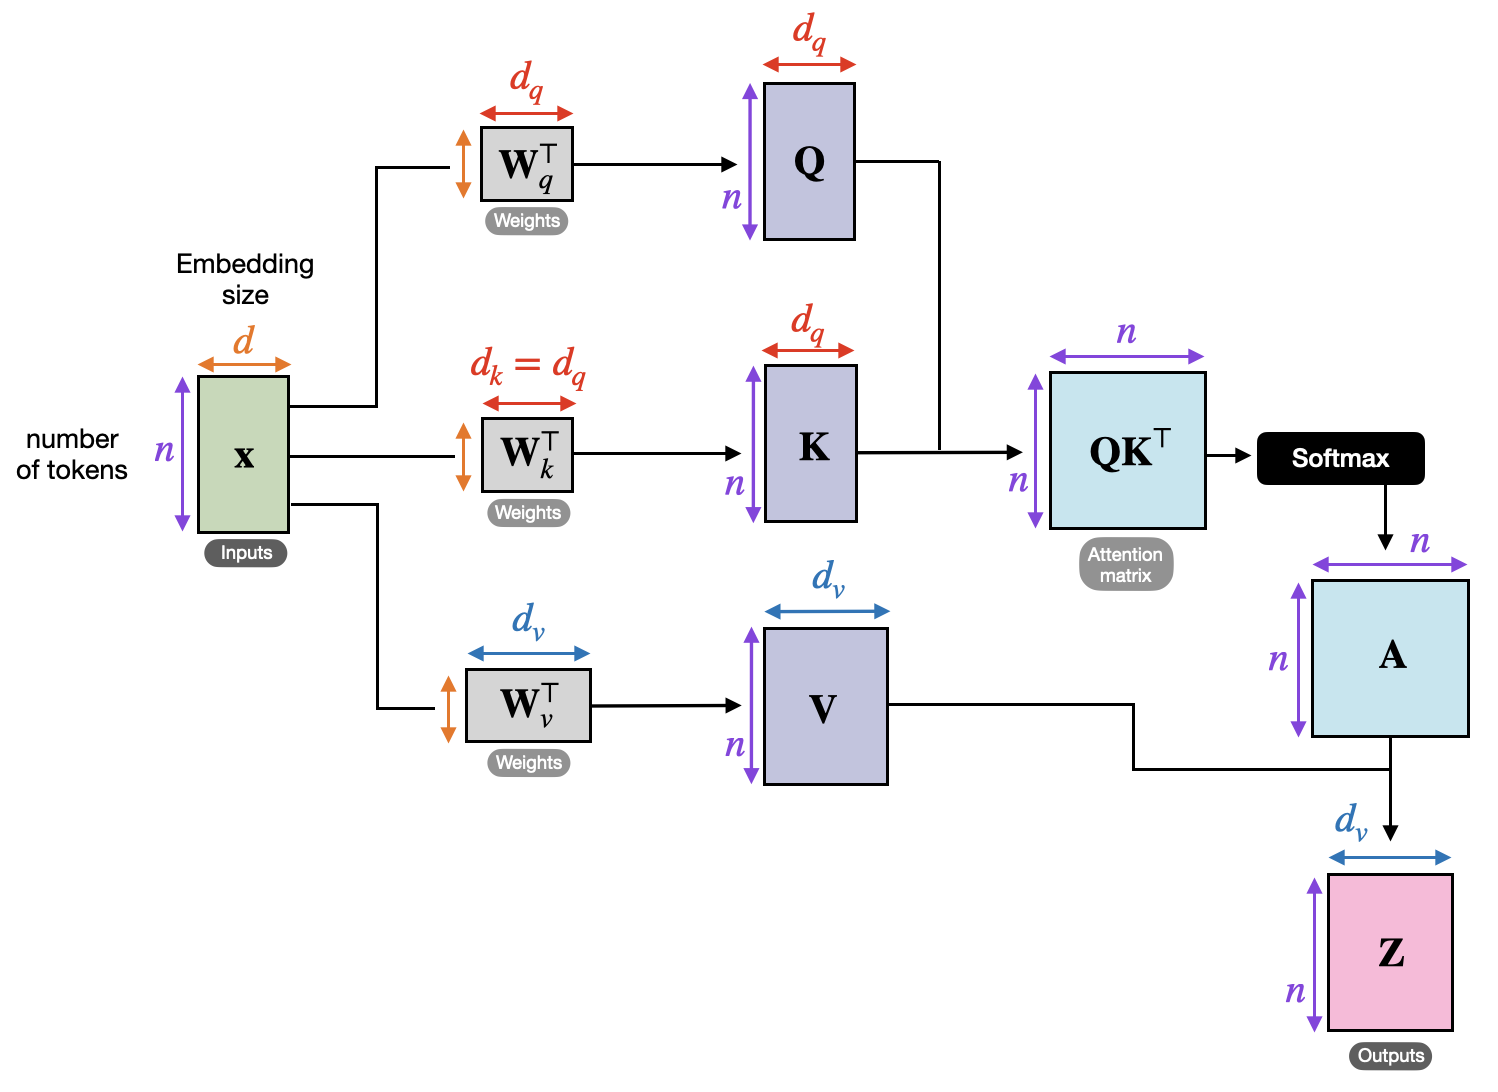

In [16]:
from IPython.display import Image
Image(filename="Images/scaled_attn.png", width=600)

### 2.1.3 visualization analysis

In [26]:
from transformers import AutoTokenizer, AutoModel

from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

from IPython.display import display, HTML

# Load require.js
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js'></script>"))

In [19]:
model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [22]:
text = 'The sun is so red like an apple'
show(model, model_type="bert", tokenizer=tokenizer, sentence_a=text, display_mode="light", layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Query (Q): “I’m the question each word asks — who should I pay attention to?”
- Key (K): “I’m the tag each word carries — do I match your question?”
- Value (V): “I’m the content each word offers — if you attend to me, here’s the information you get.”

### 2.1.4 computation of self-attention

In [28]:
model_input = tokenizer(text, return_tensors='pt', add_special_tokens=False)

# hyperparameters
config = AutoConfig.from_pretrained(model_name)

# config.vocab_size -> 30522
# config.hidden_size -> 768 = 64*12
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)

# forward of embedding module
input_embeddings = token_embedding(model_input['input_ids'])

# batch_size, seq_len, hidden_size
input_embeddings.shape

torch.Size([1, 8, 768])

#### Compute Q K V
Don't consider position encoding first.

In [37]:
query = key = value = input_embeddings
dim_k = key.size(-1)

attn_scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(dim_k)

attn_weights = torch.softmax(attn_scores, dim=-1)

attn_outputs = torch.matmul(attn_weights, value)

### Summary
to a function

In [44]:
def scaled_dot_product_attention(query, key, value):
    dim_k = key.size(-1)

    attn_scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(dim_k)
    attn_weight = torch.softmax(attn_scores, dim=-1)
    attn_outputs = torch.matmul(attn_weights, value)

    return attn_outputs

In [46]:
scaled_dot_product_attention(query, key, value)

tensor([[[ 1.0863,  0.5704, -0.7831,  ..., -1.5123,  0.3435, -1.2982],
         [-0.7263, -0.5152,  0.2232,  ..., -1.4098,  1.5296, -0.5281],
         [-1.6988,  0.5180,  1.0002,  ...,  1.5137,  1.4587, -0.0489],
         ...,
         [-1.2370, -0.9887,  0.0808,  ...,  0.2817, -0.3564, -0.1739],
         [-1.7036, -0.4461,  0.5485,  ..., -0.8034,  0.6282,  0.3569],
         [ 1.4287, -1.3077, -0.4317,  ...,  1.2138, -1.3269, -1.4525]]],
       grad_fn=<UnsafeViewBackward0>)